In [36]:
import math

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [37]:
class System_mm1k:
    def __init__(self, lmd, mu, K):
        self.lmd = lmd
        self.mu = mu
        self.K = K
        
    def solve(self):
        rho = self.lmd / self.mu

        def p_k(k):
            if rho == 1:
                return 1 / (self.K + 1)
            else:
                return ((1 - rho) * rho ** k) / (1 - rho ** (self.K + 1))

        rej_rate = p_k(self.K)
        E_L = sum(k * p_k(k) for k in range(0, self.K + 1))
        E_Lq = sum((k - 1) * p_k(k) for k in range(1, self.K + 1))
        util_rate = rho
        # util_rate = rho * (1 - rej_rate)
        
        return rej_rate, E_L, E_Lq, util_rate
    

    def simulate(self, simulation_time):

        def next_arrival():
            return np.random.exponential(1 / self.lmd)

        def next_departure():
            return np.random.exponential(1 / self.mu)

        t = 0  # 現在の時刻
        k = 0  # 現在のシステム内人数

        next_arrival_time = next_arrival()  # 初回到着時間
        next_departure_time = float('inf')  # 初回サービス終了時間（初期は無限）
        
        arrived = 0
        rejected = 0
        total_sys = 0
        total_waiting = 0
        busy_time = 0  # サーバーが忙しい時間の累積

        last_event_time = 0  # 前回イベントが発生した時刻
        ea = 0

        while t < simulation_time:
            if next_arrival_time < next_departure_time:  # 到着イベント
                t = next_arrival_time
                ea = t - last_event_time

                total_sys += ea * k
                total_waiting += ea * max(0, k-1)
                
                arrived += 1
                if k > 0:  # サーバーが忙しい場合、前回イベントとの経過時間を加算
                    busy_time += ea
                else:
                    next_departure_time = t + next_departure()
                if k < self.K:
                    k += 1
                else:
                    rejected += 1
                next_arrival_time = t + next_arrival()  # 次の到着時間を計算
            else:  # サービス終了イベント
                t = next_departure_time
                ea = t - last_event_time

                total_sys += ea * k
                total_waiting += ea * max(0, k-1)

                busy_time += ea
                k -= 1
                if k > 0:
                    next_departure_time = t + next_departure()
                else:
                    next_departure_time = float('inf')  # サーバーが空なら無限大

            last_event_time = t  # 現在の時刻を更新
            
        rej_rate = rejected / arrived
        E_L = total_sys / t
        E_Lq = total_waiting / t
        util_rate = busy_time / t

        return rej_rate, E_L, E_Lq, util_rate

    
# テストパラメータ
lmd = 5.0  # 到着率（λ）
mu = 10.0   # サービス率（μ）
simulation_time = 100000

results_K = []
results_solve = {"rej_rate": [], "E_L": [], "E_Lq": [], "util_rate": []}
results_sim = {"rej_rate": [], "E_L": [], "E_Lq": [], "util_rate": []}

# シミュレーション実行
# for K in [5, 10]:
for K in range(1, 21):
    system = System_mm1k(lmd, mu, K)
    results_K.append(K)
    rej_rate, E_L, E_Lq, util_rate = system.solve()
    results_solve["rej_rate"].append(rej_rate)
    results_solve["E_L"].append(E_L)
    results_solve["E_Lq"].append(E_Lq)
    results_solve["util_rate"].append(util_rate)

    rej_rate, E_L, E_Lq, util_rate = system.simulate(simulation_time)
    results_sim["rej_rate"].append(rej_rate)
    results_sim["E_L"].append(E_L)
    results_sim["E_Lq"].append(E_Lq)
    results_sim["util_rate"].append(util_rate)




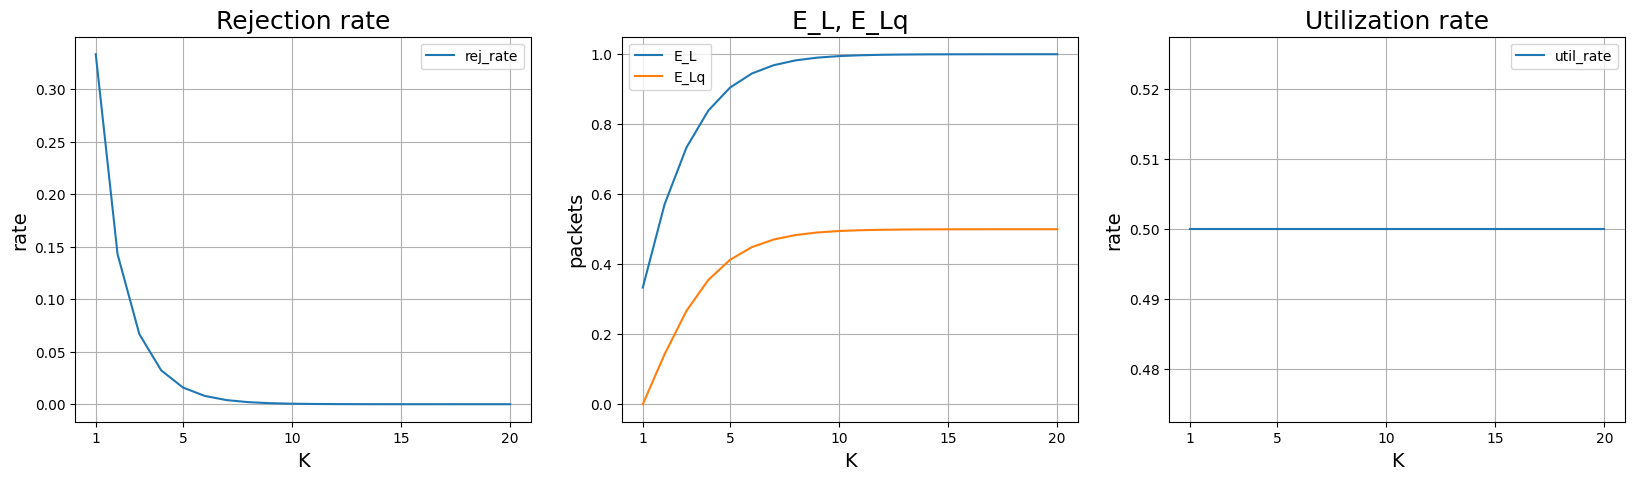

In [47]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(20, 5))  # Adjust the size if needed

# First subplot
x = results_K
y = results_solve["rej_rate"]
ax[0].plot(x, y, label="rej_rate")
ax[0].set_xlabel("K", fontsize=14)
ax[0].set_ylabel("rate", fontsize=14)
ax[0].set_xticks([1, 5, 10, 15, 20])
ax[0].grid()
ax[0].legend()

# Second subplot
x = results_K
y = results_solve["E_L"]
ax[1].plot(x, y, label="E_L")

y = results_solve["E_Lq"]
ax[1].plot(x, y, label="E_Lq")

ax[1].set_xlabel("K", fontsize=14)
ax[1].set_ylabel("packets", fontsize=14)
ax[1].set_xticks([1, 5, 10, 15, 20])
ax[1].grid()
ax[1].legend()

# Third subplot
x = results_K
y = results_solve["util_rate"]
ax[2].plot(x, y, label="util_rate")

ax[2].set_xlabel("K", fontsize=14)
ax[2].set_ylabel("rate", fontsize=14)
ax[2].set_xticks([1, 5, 10, 15, 20])
ax[2].grid()
ax[2].legend()

ax[0].set_title("Rejection rate", fontsize=18)
ax[1].set_title("E_L, E_Lq", fontsize=18)
ax[2].set_title("Utilization rate", fontsize=18)

plt.show()



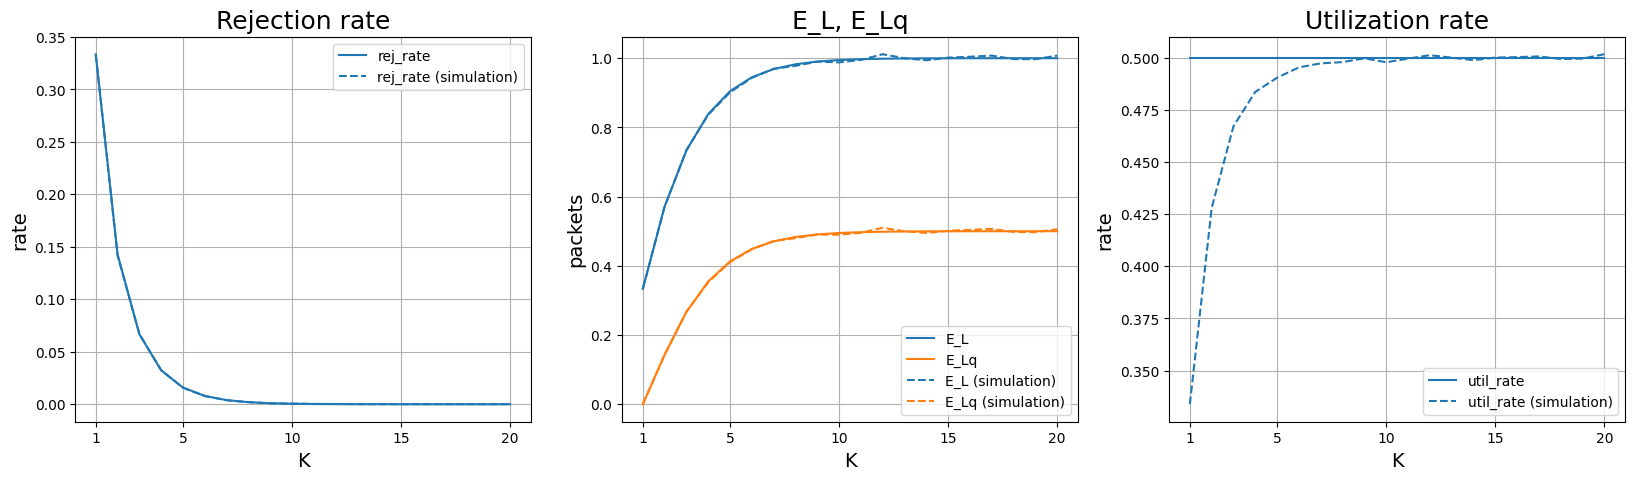

In [48]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))  # Adjust the size if needed

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# First subplot
x = results_K
y = results_solve["rej_rate"]
ax[0].plot(x, y, label="rej_rate", color=colors[0])
y = results_sim["rej_rate"]
ax[0].plot(x, y, label="rej_rate (simulation)", color=colors[0], ls="--")
ax[0].set_xlabel("K", fontsize=14)
ax[0].set_ylabel("rate", fontsize=14)
ax[0].set_xticks([1, 5, 10, 15, 20])
ax[0].grid()
ax[0].legend()

# Second subplot
x = results_K
y = results_solve["E_L"]
ax[1].plot(x, y, label="E_L", color=colors[0])

y = results_solve["E_Lq"]
ax[1].plot(x, y, label="E_Lq", color=colors[1])

y = results_sim["E_L"]
ax[1].plot(x, y, label="E_L (simulation)", color=colors[0], ls="--")

y = results_sim["E_Lq"]
ax[1].plot(x, y, label="E_Lq (simulation)", color=colors[1], ls="--")

ax[1].set_xlabel("K", fontsize=14)
ax[1].set_ylabel("packets", fontsize=14)
ax[1].set_xticks([1, 5, 10, 15, 20])
ax[1].grid()
ax[1].legend()

# Third subplot
x = results_K
y = results_solve["util_rate"]
ax[2].plot(x, y, label="util_rate", color=colors[0])
y = results_sim["util_rate"]
ax[2].plot(x, y, label="util_rate (simulation)", color=colors[0], ls="--")
ax[2].set_xlabel("K", fontsize=14)
ax[2].set_ylabel("rate", fontsize=14)
ax[2].set_xticks([1, 5, 10, 15, 20])
ax[2].grid()
ax[2].legend()

ax[0].set_title("Rejection rate", fontsize=18)
ax[1].set_title("E_L, E_Lq", fontsize=18)
ax[2].set_title("Utilization rate", fontsize=18)

plt.show()



In [40]:
# lmd = 0.5  # 到着率（λ）
# mu = 0.75   # サービス率（μ）

# for K in range(1, 21):
#     system = System_mm1k(lmd, mu, K)
#     results_K.append(K)
#     print(K, system.solve())
#     # rej_rate, E_L, E_Lq, util_rate = system.solve()
#     # results_solve["rej_rate"].append(rej_rate)
#     # results_solve["E_L"].append(E_L)
#     # results_solve["E_Lq"].append(E_Lq)
#     # results_solve["util_rate"].append(util_rate)
    


